# Spam Classification

Objective: Determine whether an SMS message should be considered spam, or not spam. 

This Presentation will show my solution to the problem of how to classify an SMS message as either spam, or not spam using machine learning algorithms. My solution will be used to predict whether the contents of an SMS message is a legitimate message, or a spam message. This solution could be used to effectively flag or block SMS messages that are classified as spam. 
In this presentation I will show how I designed my solution, and how the solution was implemented.

# Initialize and Download Data

Here I import the necessary libraries for the problem and force the use of python 3.7 and scikitlearn 1.0.1 or above.
I also set a random seed with the library numpy. 
I will be using matplotlib, wordcloud, and seaborn for visuals for analyzing data and results.

In [3]:
import sys
from packaging import version
import sklearn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import seaborn as sns
import numpy as np
from sklearn.model_selection import cross_val_score

assert sys.version_info >= (3, 7)
assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

np.random.seed(42)

Initializing fonts and sizes for matplotlib for visuals

In [2]:
plt.rc('font', size=12)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=12)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

Here I am creating a directory for the data to be stored in, then I am downloading and uncompressing the data. 

In [3]:
!mkdir datasets
%cd datasets
!wget 'https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip'
!unzip smsspamcollection.zip


/content/datasets
--2023-02-14 17:18:51--  https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 203415 (199K) [application/x-httpd-php]
Saving to: ‘smsspamcollection.zip’

smsspamcollection.z 100%[===================>] 198.65K  --.-KB/s    in 0.1s    

2023-02-14 17:18:51 (1.75 MB/s) - ‘smsspamcollection.zip’ saved [203415/203415]

Archive:  smsspamcollection.zip
  inflating: SMSSpamCollection       
  inflating: readme                  


Here I am using the Pandas library to load the data into a dataframe to be able to properly examine and utilize the data. 

In [4]:
df = pd.read_csv('/content/datasets/SMSSpamCollection', sep='\t', header=None, names=['label', 'message'])

# Exploring and visualizing data

In [5]:
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
df.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


Here I am making two different dataframes for ham and spam messages so I can explore the data of each.

In [8]:
ham_msg = df[df.label =='ham']
spam_msg = df[df.label=='spam']

ham_msg_text = " ".join(ham_msg.message.to_numpy().tolist())
spam_msg_text = " ".join(spam_msg.message.to_numpy().tolist())

Here is a word cloud of commonly used words in legitimate or ham messages.

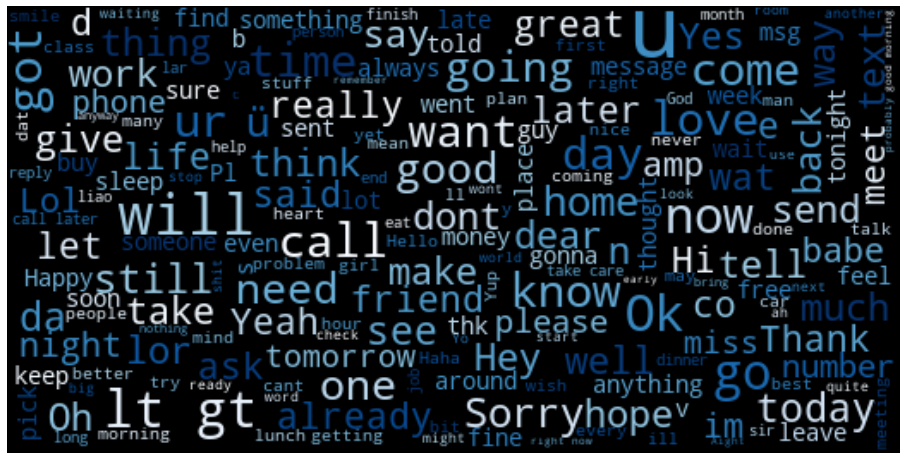

In [9]:
ham_msg_cloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50, background_color ="black", colormap='Blues').generate(ham_msg_text)
plt.figure(figsize=(16,10))
plt.imshow(ham_msg_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

Here is a word cloud of commonly used words in spam messages

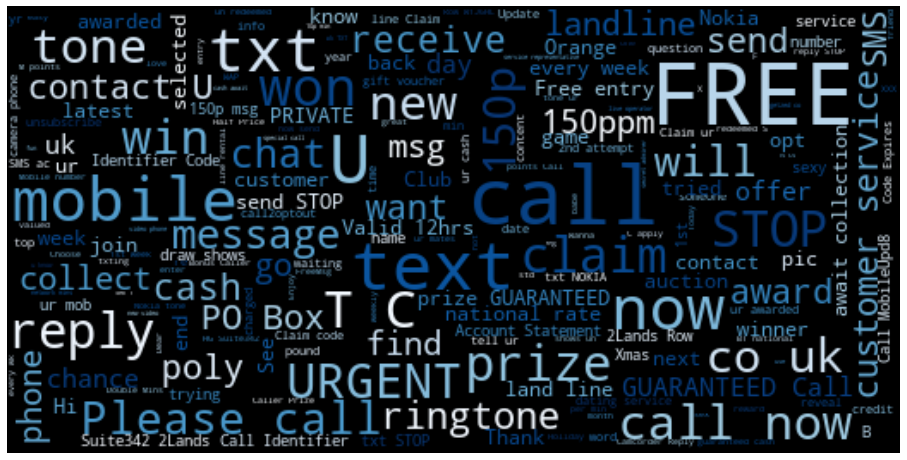

In [10]:
spam_msg_cloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50, background_color ="black", colormap='Blues').generate(spam_msg_text)
plt.figure(figsize=(16,10))
plt.imshow(spam_msg_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

Here is a graph showing the number of ham messages compared to spam messages, and the percentage of spam messages is around 15.5 percent of all the data. 

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


15.481865284974095

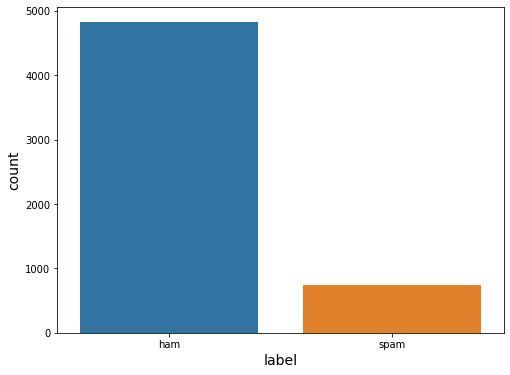

In [11]:
plt.figure(figsize=(8,6))
sns.countplot(df.label)
(len(spam_msg)/len(ham_msg))*100 # 15.48%

# Data Preparation

Looking at the data, we can see that there are duplicate messages because there are a total of 5,572 messages, but only 5,160 of them are unique.

In [12]:
df.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


Here we can see that there are a total of 403 duplicates in our data

In [14]:
print("Number of duplicates:", df.duplicated().sum())

Number of duplicates: 403


To clean up the data, I have dropped the duplicates.

In [15]:
df = df.drop_duplicates()

In [16]:
df.describe()

,label,message
count,5169,5169
unique,2,5169
top,ham,"Go until jurong point, crazy.. Available only ..."
freq,4516,1


We can get the length of a message by setting a new column to how many characters are in a message. A model can use length of a message to help learn and determine how to classify data.

In [17]:
df['length']=df['message'].apply(len)
df.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


Here we can see the number of characters in messages for each ham and spam messages.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f63b49b0040>,
      dtype=object)

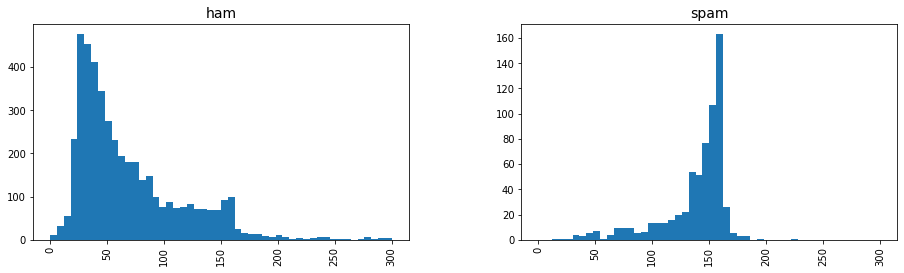

In [18]:
#Makes a histogram that displays amount of messages(y), and the amount of characters in them(x).
df.hist(column='length', by='label', range=[0, 300], bins=50,  figsize=(15, 4))

Here I convert the classes that the data is classified with into numerical values so the model can interpret it. 

In [19]:
#Changes the contents of the label column to numerical values for classification
df.loc[:, 'label']=df.label.map({'ham':0, 'spam':1})
df.head()

,label,message,length
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61


## Splitting data into training and test sets

This code shows me using the count vectorizer which is used to tokenize text so that I can use the data in the sms messages in a machine learning model

I am also splitting the data from the dataset up into two different sets which are training and test sets. The training sets are 80% of the data used in the dataset while the test set is the remaining 20%. The training set is used to train the model to make predictions while the test set is used to validate and verify the training of the model. 

In [20]:
from pandas.core.common import random_state
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

#Count vectorizer converts text into a matrix of token counts
count = CountVectorizer()
text = count.fit_transform(df['message'])

x_train, x_test, y_train, y_test = train_test_split(text, df['label'], test_size=0.20, random_state=42)

In [21]:
print(x_train.shape)
print(x_test.shape)

(4135, 8713)
(1034, 8713)


# Implementation of Naive Bayes Model

In [22]:
from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB()
model.fit(x_train, y_train)

MultinomialNB()

In [23]:
prediction = model.predict(x_test)

In [25]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print("Naive Bayes Model Results")
print("Accuracy score: ", format(accuracy_score(y_test, prediction)))
print("Precision score: ", format(precision_score(y_test, prediction)))
print("Recall: ", format(recall_score(y_test, prediction)))
print("F1 Score: ", format(f1_score(y_test, prediction)))

Naive Bayes Model Results
Accuracy score:  0.9758220502901354
Precision score:  0.891156462585034
Recall:  0.9357142857142857
F1 Score:  0.9128919860627177


# Implementation of Support Vector Machine Model

In [26]:
from sklearn.svm import LinearSVC

model = LinearSVC(random_state=1)
model.fit(x_train, y_train)

LinearSVC(random_state=1)

In [27]:
prediction = model.predict(x_test)

In [28]:
print("Support Vector Machine Model Results")
print("Accuracy score: ", format(accuracy_score(y_test, prediction)))
print("Precision score: ", format(precision_score(y_test, prediction)))
print("Recall: ", format(recall_score(y_test, prediction)))
print("F1 Score: ", format(f1_score(y_test, prediction)))

Support Vector Machine Model Results
Accuracy score:  0.9835589941972921
Precision score:  1.0
Recall:  0.8785714285714286
F1 Score:  0.935361216730038


# Implementation of Neural Network MLP Classifier

In [29]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier()
model.fit(x_train, y_train)

MLPClassifier()

In [30]:
prediction = model.predict(x_test)

In [31]:
print("MLP Classifier Results")
print("Accuracy score: ", format(accuracy_score(y_test, prediction)))
print("Precision score: ", format(precision_score(y_test, prediction)))
print("Recall: ", format(recall_score(y_test, prediction)))
print("F1 Score: ", format(f1_score(y_test, prediction)))

MLP Classifier Results
Accuracy score:  0.9874274661508704
Precision score:  0.9922480620155039
Recall:  0.9142857142857143
F1 Score:  0.9516728624535317


# Decision to use Naive Bayes Model and fine tuning

In [32]:
from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB(alpha=.01, fit_prior=True)
model.fit(x_train, y_train)

MultinomialNB(alpha=0.01)

In [33]:
prediction = model.predict(x_test)

In [35]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print("Naive Bayes Model Results")
print("Accuracy score: ", format(accuracy_score(y_test, prediction)))
print("Precision score: ", format(precision_score(y_test, prediction)))
print("Recall: ", format(recall_score(y_test, prediction)))
print("F1 Score: ", format(f1_score(y_test, prediction)))

Naive Bayes Model Results
Accuracy score:  0.9758220502901354
Precision score:  0.891156462585034
Recall:  0.9357142857142857
F1 Score:  0.9128919860627177


In [36]:
cross_val_score(model, x_train, y_train, cv=3, scoring="accuracy")

array([0.97679478, 0.97097242, 0.98548621])

Hyper Parameter Notes: 
These are just notes I took while expirementing with hyper parameters

---
fit_prior=True: Accuracy score:  0.9856502242152466 | Recall:  0.9530201342281879 | F1 Score:  0.9466666666666667 | array([0.98115747, 0.97846568, 0.98047138])


---
fit_prior=False: Accuracy score:  0.967713004484305 | Recall:  0.9530201342281879 | F1 Score:  0.8875000000000001 | array([0.96366083, 0.96904441, 0.97104377])


---
alpha=2: Accuracy score:  0.9856502242152466 | Recall:  0.9328859060402684 | F1 Score:  0.9455782312925171 | array([0.97644684, 0.98115747, 0.97508418])


---
alpha=.5: Accuracy score:  0.9838565022421525 | Recall:  0.959731543624161 | F1 Score:  0.9407894736842105 | array([0.97711978, 0.97913863, 0.98114478])

alpha=.01: Accuracy score:  0.9874439461883409 | Recall:  0.959731543624161 | F1 Score:  0.9533333333333331 | array([0.97711978, 0.97913863, 0.98114478])







# Hyperparameter Fine Tuning

While testing the model, I expiremented with two different hyper parameters for the Naive Bayes model which were the fit_prior parameter, and the alpha parameter. The alpha parameter is the parameter for smoothing, and the fit_prior parameter is for telling the model to learn with or without class prior probabilities. During my testing, I discovered that leaving the fit_prior set to true yeilded the same results as it would if it was false, but the accuracy was higher with it enabled. For the alpha parameter, I discovered that the lower the value, the better the recall score I got. I decided to set the alpha value to .01 and left the prior_fit parameter enabled. Below are the cross validation score results from these parameters. 

In [36]:
cross_val_score(model, x_train, y_train, cv=3, scoring="accuracy")

array([0.97679478, 0.97097242, 0.98548621])

# Make Classification Predictions

Lastly, I decided to test out the model using data outside of the training set and the test set to understand if the model was prepared to be implemented.

In [37]:
new_text = ["Hey man, would you want to grab some food together later?"]

new_data = count.transform(new_text)

y_pred = model.predict(new_data)

print("Predicted label: ", y_pred)

Predicted label:  [0]


In [38]:
new_text = ["Congratulations man! I heard you won that scholarship for $5,000, gud job!"]

new_data = count.transform(new_text)

y_pred = model.predict(new_data)

print("Predicted label: ", y_pred)

Predicted label:  [0]


In [39]:
new_text = ["Congratulations! You've won a $1,000 Walmart gift card. Go to http://bit.ly/123456 tp claim now."]

new_data = count.transform(new_text)

y_pred = model.predict(new_data)

print("Predicted label: ", y_pred)

Predicted label:  [1]


In [40]:
new_text = ["Jazlyn with Wallmarts Cash Back office you must claim your annual|yearly} 5OO online credit. Continue immediately bwntyy.xyz/R2YGUwoRLi"]

new_data = count.transform(new_text)

y_pred = model.predict(new_data)

print("Predicted label: ", y_pred)

Predicted label:  [1]


In [41]:
new_text = ["G-911264 is your Google verification code."]

new_data = count.transform(new_text)

y_pred = model.predict(new_data)

print("Predicted label: ", y_pred)

Predicted label:  [0]


# Implementation

# The End

# Resources 
These are some resources I used for solving problems and research

https://towardsdatascience.com/nlp-spam-detection-in-sms-text-data-using-deep-learning-b8632db85cc8

https://machinelearningmastery.com/clean-text-machine-learning-python/

https://youtu.be/mPW9bjVXbPU?list=LL

data link = https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip